In [1]:
%matplotlib inline

import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import bayes_net_utils as bn

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

plt.style.use('ggplot')

# Introduction

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Predict_with_BN.ipynb and either compares predictions produced using different kinds of met data, or compares predictions to observations from the lake. 

In [2]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_era5_fpath = '../Data/Predictions/Historic/GBN_prediction_era5_1981-2018.csv'
sim_metno_fpath = '../Data/Predictions/Historic/GBN_prediction_metno_1981-2018.csv'
sim_nomet_fpath = '../Data/Predictions/Historic/GBN_prediction_nomet_1981-2018.csv'
sim_naive_fpath = '../Data/Predictions/Historic/Prediction_naive_1981-2019.csv'

out_folder = '../Hindcast_stats_plots'

var_list = ['TP','chla','colour','cyano']

# Read in data and reformat

## Observations

In [3]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# Reformat obs to long format, same as the others
obs = pd.melt(obs_wide, id_vars=['year'], value_vars=var_list,
         var_name='node', value_name='obs')

obs.tail()

,year,node,obs
151,2015,cyano,0.233
152,2016,cyano,0.166
153,2017,cyano,0.258
154,2018,cyano,0.614
155,2019,cyano,0.592


In [4]:
# Classify the observations

# Dictionary of thresholds to use. N.B. Also defined in bayes_net_utils.R (as boundaries_list)
boundaries_dict = {'TP': 29.5,     # Middle of 'Moderate' class
                   'chla': 20.0,   # M-P boundary. WFD boundaries: [10.5, 20.0]. Only 6 observed points under 10.5 so merge G & M
                   'colour': 48.0, # 66th percentile (i.e. upper tercile). No management implications
                   'cyano': 1.0    # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho
                  }

obs_disc = obs.copy()
obs_disc['obs'] = obs[['node','obs']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.obs), axis=1)
obs_disc.head()

,year,node,obs
0,1981,TP,0.0
1,1982,TP,0.0
2,1983,TP,1.0
3,1984,TP,0.0
4,1985,TP,1.0


## Seasonal naive prediction
i.e. prediction for the current season is the prediction for the previous (corresponding) season

In [5]:
# sim_naive_wide = pd.read_csv(sim_naive_fpath)

# # Reformat obs to long format, same as the others
# sim_naive = pd.melt(sim_naive_wide, id_vars=['year'], value_vars=var_list,
#             var_name='node', value_name='sim_naive')

# sim_naive_disc = sim_naive.copy()
# sim_naive_disc['sim_naive'] = sim_naive_disc[['node','sim_naive']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.sim_naive), axis=1)
# sim_naive_disc.head(2)

sim_naive_raw = pd.read_csv(sim_naive_fpath)

# Pick out just the expected value
sim_naive = sim_naive_raw[['year','node','expected_value']]
sim_naive.columns = ['year','node','sim_naive'] # Rename columns
display(sim_naive.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_naive_disc = sim_naive_raw[['year','node','WFD_class']]
sim_naive_disc.columns = ['year','node','sim_naive']
display(sim_naive_disc.head(2))

,year,node,sim_naive
0,1981,TP,43.573016
1,1982,TP,28.833333


,year,node,sim_naive
0,1981,TP,1.0
1,1982,TP,0.0


## BN predictions

In [6]:
# Read in predictions driven by ERA5 met data and reformat to same format as obs
sim_era5_raw = pd.read_csv(sim_era5_fpath)

# Pick out just the expected value
sim_era5 = sim_era5_raw[['year','node','expected_value']]
sim_era5.columns = ['year','node','sim_era5'] # Rename columns
display(sim_era5.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_era5_class = sim_era5_raw[['year','node','WFD_class']]
sim_era5_class.columns = ['year','node','sim_era5']
display(sim_era5_class.head(2))

,year,node,sim_era5
0,1981,chla,19.4
1,1981,colour,28.3


,year,node,sim_era5
0,1981,chla,0
1,1981,colour,0


In [7]:
# Read in predictions from BN with met nodes, met.no data
sim_metno_raw = pd.read_csv(sim_metno_fpath)

# Pick out just the expected value
sim_metno = sim_metno_raw[['year','node','expected_value']]
sim_metno.columns = ['year','node','sim_metno'] # Rename columns
display(sim_metno.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_metno_class = sim_metno_raw[['year','node','WFD_class']]
sim_metno_class.columns = ['year','node','sim_metno']
display(sim_metno_class.head(2))

,year,node,sim_metno
0,1981,chla,20.0
1,1981,colour,28.0


,year,node,sim_metno
0,1981,chla,1
1,1981,colour,0


In [8]:
# BN predictions, no met nodes
sim_nomet_raw = pd.read_csv(sim_nomet_fpath)

# Pick out just the expected value
sim_nomet = sim_nomet_raw[['year','node','expected_value']]
sim_nomet.columns = ['year','node','sim_nomet'] # Rename columns
display(sim_nomet.head(2))

# Discretized df, including the class prediction
sim_nomet_class = sim_nomet_raw[['year','node','WFD_class']]
sim_nomet_class.columns = ['year','node','sim_nomet']
display(sim_nomet_class.head(2))

,year,node,sim_nomet
0,1981,chla,19.6
1,1981,colour,27.1


,year,node,sim_nomet
0,1981,chla,0
1,1981,colour,0


## Merge observations and predictions from all kinds of model

In [9]:
def merge_model_predictions(df_list):
    df = df_list[0].copy().set_index(['year','node'])
    for i, new_df in enumerate(df_list):
        new_df = new_df.set_index(['year','node'])
        if i>=1:
            df = df.join(new_df)
    df = df.reset_index()
    return df

In [10]:
# Make a dataframe of continuous data (expected values)
df_li = [obs,
#          sim_era5,
         sim_metno,
         sim_nomet,
         sim_naive]

df_cont = merge_model_predictions(df_li)

df_cont.tail()

,year,node,obs,sim_metno,sim_nomet,sim_naive
151,2015,cyano,0.233,0.316,0.411,0.283
152,2016,cyano,0.166,0.446,0.473,0.233
153,2017,cyano,0.258,0.223,0.226,0.166
154,2018,cyano,0.614,0.338,0.405,0.258
155,2019,cyano,0.592,NaN,NaN,0.614


In [11]:
# Merge discretized timeseries into discretized dfs

df_class_list = [obs_disc,
                sim_naive_disc,
#                 sim_era5_class[['year','node','sim_era5']],
                sim_metno_class[['year','node','sim_metno']],
                sim_nomet_class[['year','node','sim_nomet']]]
                
df_classes = merge_model_predictions(df_class_list)

df_classes.tail()

,year,node,obs,sim_naive,sim_metno,sim_nomet
151,2015,cyano,0.0,0.0,0.0,0.0
152,2016,cyano,0.0,0.0,0.0,0.0
153,2017,cyano,0.0,0.0,0.0,0.0
154,2018,cyano,0.0,0.0,0.0,0.0
155,2019,cyano,0.0,0.0,NaN,NaN


# Plot time series

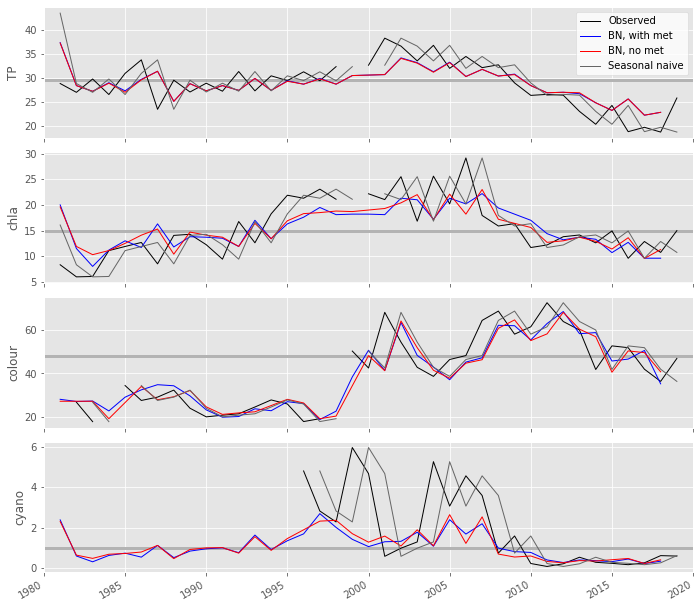

In [12]:
# Setup plot
fig, axes = plt.subplots(nrows=len(var_list), 
                         ncols=1, 
                         figsize=(10,10), 
                         sharex=True,
                        )

label_dict = {'obs':'Observed',
#              'sim_era5':'BN, ERA5',
             'sim_metno':'BN, with met',
             'sim_nomet':'BN, no met',
             'sim_naive':'Seasonal naive'}

colour_dict = {'obs':'k',
             'sim_metno':'b',
#              'sim_era5':'c',
             'sim_naive':'0.4',
             'sim_nomet':'r'}

# Loop over vars
for idx, var in enumerate(var_list):
    
    # Add WFD boundaries
    axes[idx].axhline(y=boundaries_dict[var], color='0.7', lw=3)
    
    # Plot observations and predictions
    for col in label_dict.keys():
#         if var == 'TP' and col not in ['obs','sim_era5','sim_naive']:
#             pass
#         else:
        var_series = df_cont.loc[df_cont['node'] == var, [col,'year']]
        var_series = var_series.set_index('year')

        axes[idx].plot(var_series.index, 
                       var_series.values, 
                       color=colour_dict[col], 
                       lw=1, 
                       label=label_dict[col]
                      )
    
    # Tidy
    axes[idx].set_ylabel(var)
    axes[idx].set_xlim(xmin=1980, xmax=2020)
    
    if idx==0:
        axes[idx].legend(facecolor='white')
#     axes[idx].legend(bbox_to_anchor=(1.35, 1))
    
plt.tight_layout()
fig.autofmt_xdate()
plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_gof_metno_chla.png'), dpi=300)

Using long-term mean weather from ERA5 as a constant input to the model gives almost exactly as good a prediction (compared to lake obs) as S5-driven predictions. i.e. S5 (or ERA5, for that matter) is no better than long-term average climate for any of my simulated variables. The model/lake is just too insensitive to weather, and very driven by the condition of the lake the previous year (and other things which probably aren't included in the model). On the plus, I have pretty good seasonal forecasting ability. Well, it's a result of sorts I guess...! Plenty to discuss in a paper anyway.

# Goodness of fit statistics: simulated vs observed

## Define functions to calculate continuous and discrete GoF stats

In [13]:
def gof_stats(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest
    Input:
        df: with columns 'year', 'node' (variable), 'obs', predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats    
    """
    gof_df_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        cc_li = []
        cc_sp_li = []
        mae_li = [] # mean absolute error
        rmse_li = []
        bias_li = []
        mape_li = [] # mean absolute % error
        
        for col in sim_cols_of_interest:
            
            df_test = df_var[[obs_col, col]].dropna()
            
            errors = df_test[col] - df_test[obs_col]
            
            cc = df_test[obs_col].corr(df_test[col], method='pearson')
            cc_sp = df_test[obs_col].corr(df_test[col], method='spearman')
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(((errors) ** 2)))
            bias = np.mean(errors)
            mape = np.mean(100*(errors/df_test[obs_col]))
            
            cc_li.append(cc)
            cc_sp_li.append(cc_sp)
            mae_li.append(mae)
            rmse_li.append(rmse)
            bias_li.append(bias)
            mape_li.append(mape)

        gof_df = pd.DataFrame(list(zip(cc_li, cc_sp_li, mae_li, rmse_li, bias_li, mape_li)),
                              columns = ['pearsons_cc','spearman_cc','mae','rmse','bias','mape'],
                              index = sim_cols_of_interest)

        gof_df_dict[var] = gof_df

    gof_df = pd.concat(gof_df_dict.values(), keys=gof_df_dict.keys())
    
    return gof_df

In [14]:
def gof_stats_classified_data(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest.
    See https://towardsdatascience.com/machine-learning-an-error-by-any-other-name-a7760a702c4d for a description of stats calculated,
    as well as the sklearn documentation
    
    Input:
        df: with columns 'year', 'node' (variable), observed and predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats   
    """

    gof_df_disc_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        mcc_li = [] # Matthews correlation coefficient
        roc_li = [] # ROC
        ce_li = [] # Classification error

        for col in sim_cols_of_interest:
            
            test_df = df_var[[obs_col, col]].dropna()

            mcc = matthews_corrcoef(test_df[obs_col].values, test_df[col].values)
            rocs = roc_auc_score(test_df[obs_col].values, test_df[col].values)
            ce = bn.classification_error(test_df[obs_col], test_df[col])

            mcc_li.append(mcc)
            roc_li.append(rocs)
            ce_li.append(ce)

        gof_df = pd.DataFrame(list(zip(mcc_li,
                                       roc_li,
                                      ce_li)),
                              columns = ['mathews_cc',
                                        'roc_auc_score',
                                        'classification_error'],
                              index = sim_cols_of_interest)

        gof_df_disc_dict[var] = gof_df

    gof_class_df = pd.concat(gof_df_disc_dict.values(), keys=gof_df_disc_dict.keys())
    
    return gof_class_df

## Simulated vs real lake

In [15]:
obs_col = 'obs'
sim_cols = ['sim_naive','sim_metno','sim_nomet']
st_yr = 1981

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2018.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df

pearsons_cc  spearman_cc       mae      rmse      bias  \
var    model                                                               
TP     sim_naive     0.636465     0.639165  3.421504  4.387387  0.488460   
       sim_metno     0.648770     0.639232  2.971744  3.669538 -0.037865   
       sim_nomet     0.645768     0.637253  2.985257  3.682326 -0.067594   
chla   sim_naive     0.647769     0.631105  3.613692  4.599624  0.058472   
       sim_metno     0.621562     0.594723  3.558900  4.378026 -0.082992   
       sim_nomet     0.604963     0.588926  3.490474  4.443551 -0.063263   
colour sim_naive     0.849135     0.843249  7.294954  9.207931  0.844530   
       sim_metno     0.866607     0.867507  6.369483  8.388001 -0.504655   
       sim_nomet     0.843621     0.850900  6.871679  9.048065 -0.753226   
cyano  sim_naive     0.563204     0.715415  1.192313  1.759581  0.182957   
       sim_metno     0.592783     0.717391  1.094035  1.789982 -0.819861   
       sim_nomet     0.608289     0.742278  1.067078  1.756796 -0.805774   

                       mape  mathews_cc  roc_auc_score  classification_error  
var    model                                                                  
TP     sim_naive   2.625402    0.180477       0.590774              0.405405  
       sim_metno   1.687794    0.343322       0.669118              0.324324  
       sim_nomet   1.598650    0.343322       0.669118              0.324324  
chla   sim_naive   5.053979    0.686607       0.800000              0.162162  
       sim_metno   8.294957    0.356011       0.632440              0.324324  
       sim_nomet   9.125306    0.398862       0.625000              0.324324  
colour sim_naive   5.532723    0.550848       0.779762              0.212121  
       sim_metno   2.810906    0.371206       0.678322              0.285714  
       sim_nomet   2.706364    0.441351       0.716783              0.257143  
cyano  sim_naive  76.168015    0.564902       0.784615              0.217391  
       sim_metno  24.776957    0.742424       0.871212              0.130435  
       sim_nomet  19.610268    0.742424       0.871212              0.130435

## Comparison to period used for cyanobacterial CV (1996-2019)

In [16]:
st_yr = 1996

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2018_chla15.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df.loc['cyano']

,pearsons_cc,spearman_cc,mae,rmse,bias,mape,mathews_cc,roc_auc_score,classification_error
model,,,,,,,,,
sim_naive,0.563204,0.715415,1.192313,1.759581,0.182957,76.168015,0.564902,0.784615,0.217391
sim_metno,0.592783,0.717391,1.094035,1.789982,-0.819861,24.776957,0.742424,0.871212,0.130435
sim_nomet,0.608289,0.742278,1.067078,1.756796,-0.805774,19.610268,0.742424,0.871212,0.130435


# Target plots (GoF stats summary)

In [ ]:
# # sim_cols_of_interest = ['sim_era5','sim_naive','sim_era5_av','s5_0.5_summer']
# # st_yr = 1993

# sim_cols_of_interest = ['sim_era5','sim_naive','sim_era5_av']
# st_yr = 1982

# # Setup plot
# fig, axes = plt.subplots(nrows=len(var_list), ncols=len(sim_cols_of_interest), 
#                          figsize=(12, 12), 
#                          subplot_kw={'aspect':'equal'})

# for idx, var in enumerate(var_list):
    
#     df_var = df_cont.loc[df_cont['node']==var]
#     df_var = df_var.drop('node', axis=1).set_index('year')
#     df_var = df_var.loc[st_yr:,:]  

#     for idy, col in enumerate(sim_cols_of_interest):
#         title = f'{var}, {col}'
#         nivapy.plotting.target_plot(df_var['obs'], df_var[col],
#                                    ax = axes[idx, idy],
#                                    title = title)
        
#         # Turn off axes labels for now
#         ax = axes[idx, idy]
#         ax.yaxis.label.set_visible(False)
#         ax.xaxis.label.set_visible(False)

# plt.tight_layout()
# plt.savefig(os.path.join(out_folder,'target_plots_%s-2019.png' %st_yr), dpi=200)
# plt.show()

**Interpretation:**

For TP and cyano, my BN with constant met data does better than the seasonal naive forecast at classifying

# Time series for operational model

In [ ]:
ylabel_dict = {'TP': 'TP (mg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacterial biovolume (mm$^3$/l)'}

# Loop over vars
for idx, var in enumerate(var_list):
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    
    # Add WFD boundary
    ax.axhline(y=boundaries_dict[var], color='0.7', lw=3)
    
    # Extract data
    
    # Forecasted
    if var != 'chla':
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_era5_av','year']]
    else:
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_naive','year']]
    forecasted = forecasted.set_index('year')
    
    # Observed
    obs = df_cont.loc[df_cont['node'] == var, ['obs','year']]
    obs = obs.set_index('year')
    
    # Plot forecast
    ax.plot(forecasted.index, 
            forecasted.values, 
            color='r',
            lw=1, 
            label='Forecast')
    
    # Plot observations
    ax.plot(obs.index,
           obs.values,
           color='k',
           lw=1,
           label='Observed')
    
    # Tidy
    ax.set_ylabel(ylabel_dict[var])
    ax.set_xlim(xmin=1980, xmax=2020)
    ax.legend()
    
    plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_operationalModel_%s.png' %var), dpi=150)